### Configurations and Libraries



In [ ]:
# TODO: change from mounting drive to local files
# TODO: add tests

In [73]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from numpy.typing import NDArray
import seaborn as sns
import seaborn_image as isns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from generator import RegionETGenerator


In [255]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

### Load & Describe Data

In [59]:
data_path = Path('data')
model_path = Path('model')

In [60]:
images = np.load(data_path / 'images.npy')
labels = np.load(data_path / 'labels.npy')

In [61]:
print(f"Data type of images: {images.dtype}")
print(f"Data type of labels: {labels.dtype}")

Data type of images: float64
Data type of labels: int64


In [62]:
# TODO: can we keep generic? what if it's a string?
def labels_description(data: NDArray[np.int64]) -> None:
  df = pd.DataFrame(data)
  print(df.describe())
  print(df.info())

def slice_description(data: NDArray[np.float64]) -> None:
  slice = data[0, :, :].reshape(256,)
  df = pd.DataFrame(slice)
  print(df.describe())
  print(df.info())

In [63]:
slice_description(images)

                0
count  256.000000
mean     0.955877
std      0.908362
min      0.007223
25%      0.306411
50%      0.691741
75%      1.343379
max      6.263326
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       256 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB
None


In [64]:
labels_description(labels)

                0
count  1000.00000
mean      0.50000
std       0.50025
min       0.00000
25%       0.00000
50%       0.50000
75%       1.00000
max       1.00000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       1000 non-null   int64
dtypes: int64(1)
memory usage: 7.9 KB
None


In [65]:
images_train_val, images_test, labels_train_val, labels_test = train_test_split(
    images, labels, test_size=0.2, random_state=42,)
images_train, images_val, labels_train, labels_val = train_test_split(
    images_train_val, labels_train_val, test_size=0.2, random_state=42,)

### Data Visualization

In [13]:
# TODO: check the type of pixels
def print_random_image(images: NDArray[np.float64], labels: NDArray[np.int64]) -> None:
  index = np.random.randint(0, images.shape[0])
  plt.imshow(images[index])
  plt.title(f'Label: {labels[index]}')
  plt.show()

def print_image_distribution(images: NDArray[np.float64], labels: NDArray[np.int64]) -> None:
  index = np.random.randint(0, images.shape[0])
  ax = isns.imghist(images[index])
  plt.title(f'Index: {index}, Label: {labels[index]}')

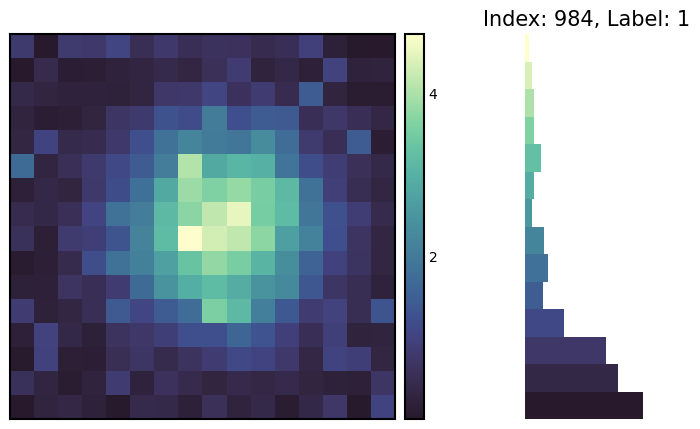

In [22]:
# TODO: histogram of pixel intensities using seaborn (or alternatives)
print_image_distribution(images, labels)

### (Tentative) Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Flip horizontally and vertically
    tf.keras.layers.RandomRotation(0.2),  # Rotate up to 20%
    tf.keras.layers.RandomZoom(0.2),  # Zoom up to 20%
    tf.keras.layers.RandomContrast(0.2),  # Change contrast
    tf.keras.layers.RandomBrightness(0.2),
])

In [189]:
augmented_images = []
for image in images_train:
    for _ in range(10):
        augmented = data_augmentation(tf.expand_dims(image, axis=0))
        augmented_images.append(tf.squeeze(augmented).numpy())
augmented_images = np.array(augmented_images)

In [ ]:
augmented_img = data_augmentation(tf.expand_dims(images[100], axis=0))
augmented_img = tf.squeeze(augmented_img)

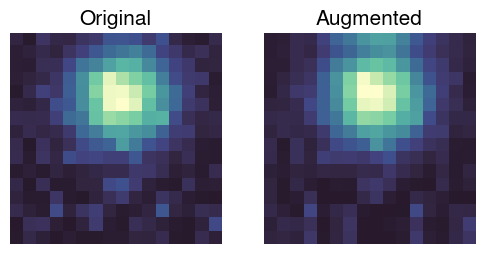

In [187]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(images[100])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Augmented")
plt.imshow(augmented_img[0, :, :])
plt.axis("off")

plt.show()

### Provided Model's Predictions

In [168]:
# TODO: again be coherent with the same format, especially if we consider quantization
# TODO: move in utils.py
def predict(model: tf.keras.Model, images: NDArray[np.float64]) -> NDArray[np.float32]:
  input_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
  output = infer(input_tensor)
  return output['lambda'].numpy()

def normalize_matrix(matrix: NDArray[np.float32]) -> NDArray[np.float32]:
  min_score = np.min(matrix)
  max_score = np.max(matrix)
  normalized_output = []
  for score in matrix:
    normalized_output.append((score - min_score)/(max_score-min_score))
  return np.array(normalized_output)

In [177]:
def plot_roc_curve(labs: NDArray[np.int32], preds: NDArray[np.float32]) -> None:
  fpr, tpr, thresholds = roc_curve(labs, preds)
  roc_auc = auc(fpr, tpr)
  # Plotting the ROC curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal line (random classifier)

  # Add labels and title
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")

  # Show plot
  plt.show()

In [178]:
#keras_model = tf.keras.models.load_model('model')
#keras_model = tf.keras.layers.TFSMLayer(model_path, call_endpoint = 'serving_default')ù
model = tf.saved_model.load(model_path)
infer = model.signatures['serving_default']

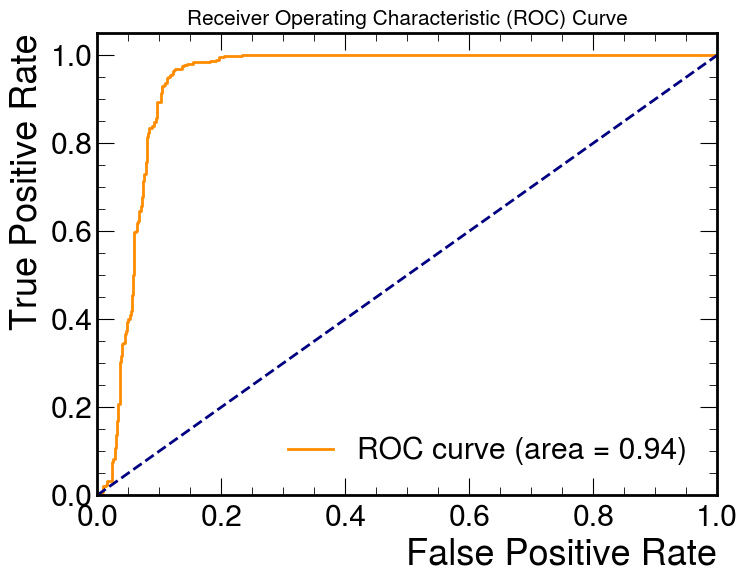

In [179]:
output = predict(model, images)
normalized_output = normalize_matrix(output)
plot_roc_curve(labels, normalized_output)
# idea: also add MSE 

### Proposed Model

In [258]:
from qkeras import QActivation, QConv2D, QDense, QDenseBatchnorm, quantized_bits
from tensorflow import keras, data
from keras.models import Model, load_model
from keras.layers import (
    Activation,
    AveragePooling2D,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    Reshape,
    UpSampling2D,
    Conv2DTranspose
)
import numpy.typing as npt
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import Adam

In [259]:
class TeacherAutoencoderRevised:
    def __init__(self, input_shape: tuple):
        self.input_shape = input_shape
    # TODO: regularization techniques, learning-rate schedulers, batch_normalization
    def get_model(self):
        inputs = Input(shape=self.input_shape, name="teacher_inputs_")
        x = Reshape((16, 16, 1), name="teacher_reshape")(inputs)
        x = Conv2D(20, (3, 3), strides=1, padding="same", name="teacher_conv2d_1")(x)
        x = Activation("relu", name="teacher_relu_1")(x)
        x = AveragePooling2D((2, 2), name="teacher_pool_1")(x)
        x = Conv2D(30, (3, 3), strides=1, padding="same", name="teacher_conv2d_2")(x)
        x = Activation("relu", name="teacher_relu_2")(x)
        x = Flatten(name="teacher_flatten")(x)
        x = Dense(80, activation="relu", name="teacher_latent")(x)
        x = Dense(8 * 8 * 30, name="teacher_dense")(x)
        x = Reshape((8, 8, 30), name="teacher_reshape2")(x)
        x = Activation("relu", name="teacher_relu_3")(x)
        x = Conv2D(30, (3, 3), strides=1, padding="same", name="teacher_conv2d_3")(x)
        x = Activation("relu", name="teacher_relu_4")(x)
        x = Conv2DTranspose(30, (3, 3), strides=2, padding="same", name="teacher_conv_transpose")(x)
        x = Conv2D(20, (3, 3), strides=1, padding="same", name="teacher_conv2d_4")(x)
        x = Activation("relu", name="teacher_relu_5")(x)
        outputs = Conv2D(
            1,
            (3, 3),
            activation="relu",
            strides=1,
            padding="same",
            name="teacher_outputs",
        )(x)
        return Model(inputs, outputs, name="teacher-transpose")


class CicadaV2:
    def __init__(self, input_shape: tuple):
        self.input_shape = input_shape

    def get_model(self):
        inputs = Input(shape=self.input_shape, name="inputs_")
        x = Reshape((16, 16, 1), name="reshape")(inputs)
        # quantized_bits takes the following arguments:
        # total number of bits used to represent each weight value
        # number of bits used to represent the integer part
        # 1 bit if signed
        # scaling factor, 1.0 means no scaling
        x = QConv2D(
            4,
            (2, 2),
            strides=2,
            padding="valid",
            use_bias=False,
            kernel_quantizer=quantized_bits(12, 3, 1, alpha=1.0),
            name="conv",
        )(x)
        x = QActivation("quantized_relu(10, 6)", name="relu0")(x)
        x = Flatten(name="flatten")(x)
        x = Dropout(1 / 9)(x)
        x = QDenseBatchnorm(
            16,
            kernel_quantizer=quantized_bits(8, 1, 1, alpha=1.0),
            bias_quantizer=quantized_bits(8, 3, 1, alpha=1.0),
            name="dense1",
        )(x)
        x = QActivation("quantized_relu(10, 6)", name="relu1")(x)
        x = Dropout(1 / 8)(x)
        x = QDense(
            1, # single output unit
            kernel_quantizer=quantized_bits(12, 3, 1, alpha=1.0),
            use_bias=False,
            name="dense2",
        )(x)
        outputs = QActivation("quantized_relu(16, 8)", name="outputs")(x)
        return Model(inputs, outputs, name="cicada-v2")


In [302]:
def loss(y_true: npt.NDArray, y_pred: npt.NDArray) -> npt.NDArray:
    return np.mean((y_true - y_pred) ** 2, axis=(1, 2, 3))

def quantize(arr: npt.NDArray, precision: tuple = (16, 8)) -> npt.NDArray:
    # word contains the number of bits, int_ #bits for the integer part then 
    # calculates the number of bits for the decimal part and the step size
    # next the function calculates the maximum value that can be represented
    # finally it quantizes the array and clips the values to the maximum and 0
    word, int_ = precision 
    decimal = word - int_
    step = 1 / 2**decimal
    max_ = 2**int_ - step
    arrq = step * np.round(arr / step)
    arrc = np.clip(arrq, 0, max_)
    return arrc

def get_student_targets(
    teacher: Model, gen: RegionETGenerator, X: npt.NDArray
) -> data.Dataset:
    X = np.expand_dims(X, axis=-1)
    X_hat = teacher.predict(X, batch_size=512, verbose=0)
    y = loss(X, X_hat) # FP32 loss
    y = quantize(np.log(y) * 32)  # Scaled FP32 loss
    # arguments: input of the teacher model, quantized loss and batch size
    return gen.get_generator(X.reshape((-1, 256, 1)), y, 128, False)

def train_model(
    model: Model,
    training_dataset: data.Dataset,
    validation_dataset: data.Dataset,
    epoch: int = 1,
    steps: int = 1,
    callbacks=None,
    verbose: bool = False,
) -> None:
    model.fit(
        training_dataset,
        steps_per_epoch=len(training_dataset), # the model process the entire dataset
        initial_epoch=epoch,
        epochs=epoch + steps,
        validation_data=validation_dataset,
        callbacks=callbacks,
        verbose=verbose,
    )


In [303]:
teacher = TeacherAutoencoderRevised((16, 16, 1)).get_model()
teacher.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
t_mc = ModelCheckpoint(f"models/{teacher.name}", save_best_only=True)
t_log = CSVLogger(f"models/{teacher.name}/training.log", append=True)

cicada_v2 = CicadaV2((256,)).get_model()
cicada_v2.compile(optimizer=Adam(learning_rate=0.001), loss="mae")
cv2_mc = ModelCheckpoint(f"models/{cicada_v2.name}", save_best_only=True)
cv2_log = CSVLogger(f"models/{cicada_v2.name}/training.log", append=True)

In [304]:
gen = RegionETGenerator()
gen_train = gen.get_generator(augmented_images, augmented_images, 8, True)
gen_val = gen.get_generator(images_val, images_val, 8)

In [305]:
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

In [306]:
for epoch in range(2):
    train_model(
        teacher,
        gen_train,
        gen_val,
        epoch=epoch,
        callbacks=[t_mc, t_log],
        verbose=1,
    )
    tmp_teacher = load_model(f"models/{teacher.name}")
    #s_gen_train = get_student_targets(tmp_teacher, gen, X_train_student)
    #s_gen_val = get_student_targets(tmp_teacher, gen, X_val_student)
    s_gen_train = get_student_targets(tmp_teacher, gen, augmented_images)
    s_gen_val = get_student_targets(tmp_teacher, gen, images_val)
    train_model(
            cicada_v2,
            s_gen_train,
            s_gen_val,
            epoch=10 * epoch,
            steps=10,
            callbacks=[cv2_mc, cv2_log],
            verbose=1,
        )

789/800 [============================>.] - ETA: 0s - loss: 0.3430INFO:tensorflow:Assets written to: models/teacher-transpose/assets


INFO:tensorflow:Assets written to: models/teacher-transpose/assets


800/800 [==============================] - 3s 4ms/step - loss: 0.3421 - val_loss: 0.5412


Epoch 1/10
49/50 [============================>.] - ETA: 0s - loss: 0.2457 INFO:tensorflow:Assets written to: models/cicada-v2/assets


INFO:tensorflow:Assets written to: models/cicada-v2/assets


50/50 [==============================] - 1s 12ms/step - loss: 0.2433 - val_loss: 0.6479
Epoch 2/10
48/50 [===========================>..] - ETA: 0s - loss: 0.0740INFO:tensorflow:Assets written to: models/cicada-v2/assets


INFO:tensorflow:Assets written to: models/cicada-v2/assets


50/50 [==============================] - 1s 18ms/step - loss: 0.0726 - val_loss: 0.5250
Epoch 3/10
49/50 [============================>.] - ETA: 0s - loss: 0.0401INFO:tensorflow:Assets written to: models/cicada-v2/assets


INFO:tensorflow:Assets written to: models/cicada-v2/assets


50/50 [==============================] - 0s 10ms/step - loss: 0.0400 - val_loss: 0.5125
Epoch 4/10
37/50 [=====================>........] - ETA: 0s - loss: 0.0314INFO:tensorflow:Assets written to: models/cicada-v2/assets


INFO:tensorflow:Assets written to: models/cicada-v2/assets


50/50 [==============================] - 1s 11ms/step - loss: 0.0301 - val_loss: 0.5112
Epoch 5/10
50/50 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.5112
Epoch 6/10
50/50 [==============================] - 0s 1ms/step - loss: 0.0182 - val_loss: 0.5112
Epoch 7/10
50/50 [==============================] - 0s 1ms/step - loss: 0.0185 - val_loss: 0.5112
Epoch 8/10
50/50 [==============================] - 0s 1ms/step - loss: 0.0176 - val_loss: 0.5112
Epoch 9/10
50/50 [==============================] - 0s 1ms/step - loss: 0.0176 - val_loss: 0.5112
Epoch 10/10
50/50 [==============================] - 0s 1ms/step - loss: 0.0177 - val_loss: 0.5112
Epoch 2/2
795/800 [============================>.] - ETA: 0s - loss: 0.2370INFO:tensorflow:Assets written to: models/teacher-transpose/assets


INFO:tensorflow:Assets written to: models/teacher-transpose/assets


800/800 [==============================] - 4s 4ms/step - loss: 0.2367 - val_loss: 0.4961


Epoch 11/20
47/50 [===========================>..] - ETA: 0s - loss: 0.0056INFO:tensorflow:Assets written to: models/cicada-v2/assets


INFO:tensorflow:Assets written to: models/cicada-v2/assets


50/50 [==============================] - 1s 10ms/step - loss: 0.0054 - val_loss: 0.1693
Epoch 12/20
50/50 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.1693
Epoch 13/20
50/50 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.1693
Epoch 14/20
50/50 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.1693
Epoch 15/20
50/50 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.1693
Epoch 16/20
50/50 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.1693
Epoch 17/20
50/50 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.1693
Epoch 18/20
50/50 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.1693
Epoch 19/20
50/50 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.1693
Epoch 20/20
50/50 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.1693


In [ ]:
import importlib
import drawing
importlib.reload(drawing)
from drawing import Draw
draw = Draw(output_dir='plots', interactive=False)

In [273]:
image_example = images_test[:1]
y_example = teacher.predict(image_example, verbose=1)
print(loss(image_example, y_example)[0])
draw.plot_reconstruction_results(
        image_example,
        y_example,
        loss=loss(image_example, y_example)[0],
        name="comparison-background",
    )

1/1 [==============================] - 0s 11ms/step
1.6601254835595078


In [281]:
y_pred_teacher = teacher.predict(images_test, verbose=1)
y_loss_teacher = loss(images_test[:, :, :, None], y_pred_teacher)
y_loss_cicada = cicada_v2.predict(images_test.reshape((-1, 256)), verbose=1)

7/7 [==============================] - 0s 486us/step
